# Phase 3 Project — Tanzania Water Well Classification

Prepared by: Richecard Blade DAMEUS

Instructor: Wedter Jerome

### **Introduction**

Access to safe and clean water is crucial for public health, especially in rural areas. In Tanzania, the effectiveness of water well installations can significantly affect communities' access to potable water. However, maintaining these water points efficiently remains a challenge, as some wells can become non-functional over time, requiring repairs or replacements. NGOs and government agencies responsible for maintaining water wells need a reliable system to predict and prioritize the wells that need urgent attention.

This project aims to develop a machine learning classifier that predicts the condition of water points based on various factors, such as installation details, geographical location, and historical maintenance data. By using this model, stakeholders can prioritize interventions and ensure that the resources are directed where they are most needed, helping to improve access to clean water.

### **Tasks and Methodology**

### 1. Business & Data Understanding

The first task was to thoroughly understand the business problem and the data provided:

**Business Problem:** The primary goal is to predict the status of water wells, i.e., whether they are functional, need repair, or are non-functional.

**Target Variable:** The model predicts the status_group of water wells, classified into three categories: functional, functional needs repair, and non functional.

**Features:** Key features include technical aspects like the well’s installation and maintenance history (installer, funder, amount_tsh), geographic data (gps_height, latitude, longitude), and temporal data (construction_year, date_recorded).

The business challenge lies in ensuring that repairs are prioritized for wells that are non-functional or need repairs, as these directly impact water access. An effective classifier will minimize both false positives (unnecessary site visits) and false negatives (missed repairs), thus saving time and resources.

### 2. Data Loading and Preprocessing

The next step was to load and preprocess the data to make it suitable for machine learning:

In [2]:
import pandas as pd
import numpy as np
import json
from pathlib import Path

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score, recall_score
)
from scipy.stats import randint

In [13]:
# Load the data
df1 = pd.read_csv("4910797b-ee55-40a7-8668-10efd5c1b960.csv")
df2 = pd.read_csv("0bf8bc6e-30d0-4c50-956a-603fc693d966.csv")

# Filter numerical columns from df1
df1 = df1.select_dtypes(include="number")

# Show the shapes and preview of the datasets
df1.shape, df2.shape
df1.head(), df2.head()

(      id  amount_tsh  gps_height  longitude   latitude  num_private  \
 0  69572      6000.0        1390  34.938093  -9.856322            0   
 1   8776         0.0        1399  34.698766  -2.147466            0   
 2  34310        25.0         686  37.460664  -3.821329            0   
 3  67743         0.0         263  38.486161 -11.155298            0   
 4  19728         0.0           0  31.130847  -1.825359            0   
 
    region_code  district_code  population  construction_year  
 0           11              5         109               1999  
 1           20              2         280               2010  
 2           21              4         250               2009  
 3           90             63          58               1986  
 4           18              1           0                  0  ,
       id    status_group
 0  69572      functional
 1   8776      functional
 2  34310      functional
 3  67743  non functional
 4  19728      functional)

## 3. Data Understanding & EDA

In [4]:
# Merge y into X for EDA (train only)
df = df1.merge(df2, on='id', how='left')
df['status_group'].value_counts(normalize=True).rename('class_share')

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: class_share, dtype: float64

#### Label Encoding: Converting Categorical Target Variable to Numeric Values

In this analysis, I needed to convert the target variable `status_group` (which has three categories) into numeric values in order to train my model. This is a **classification problem**, and to do this, I used `LabelEncoder` from `sklearn`, which transforms the categories into numbers.

- **Functional** → `0`
- **Functional needs repair** → `1`
- **Non functional** → `2`

This transformation allows the model to interpret the target variable as numeric, which is necessary for machine learning algorithms like **Logistic Regression** or **Random Forest**.

In [14]:
label_encoder = LabelEncoder()
df["status_group"] = label_encoder.fit_transform(df['status_group'])

In [15]:
# Missingness and basic info
missing = df.isna().mean().sort_values(ascending=False).head()
cardinality = df.nunique().sort_values(ascending=False).head()
df

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999,0
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010,0
2,34310,25.0,686,37.460664,-3.821329,0,21,4,250,2009,0
3,67743,0.0,263,38.486161,-11.155298,0,90,63,58,1986,2
4,19728,0.0,0,31.130847,-1.825359,0,18,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,1210,37.169807,-3.253847,0,3,5,125,1999,0
59396,27263,4700.0,1212,35.249991,-9.070629,0,11,4,56,1996,0
59397,37057,0.0,0,34.017087,-8.750434,0,12,7,0,0,0
59398,31282,0.0,0,35.861315,-6.378573,0,1,4,0,0,0


## 5. Split & Preprocessing

In this step, we split the data into training and validation sets. The target variable `status_group` (which contains the categories: `functional`, `functional needs repair`, `non functional`) is separated from the features. The data is then split into training and validation sets with a ratio of 80% for training and 20% for validation. This is done using **train_test_split**, with stratification applied to ensure the distribution of the target variable is consistent across both sets.

The following steps are carried out:
- **Target Variable (`y`)**: The `status_group` column from `df2`.
- **Features (`X`)**: All the numerical columns from `df1`.

In [7]:
y = df2['status_group']
X = df1

X_tr, X_va, y_tr, y_va = train_test_split( 
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_tr.shape, X_va.shape, y_tr.value_counts(normalize=True), y_va.value_counts(normalize=True)

((47520, 10),
 (11880, 10),
 functional                 0.543077
 non functional             0.384238
 functional needs repair    0.072685
 Name: status_group, dtype: float64,
 functional                 0.543098
 non functional             0.384259
 functional needs repair    0.072643
 Name: status_group, dtype: float64)

In [16]:
# Create a pipeline for preprocessing and training the model

num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_tf = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler(with_mean=False))  # sparse-safe
])

preprocess = ColumnTransformer([
    ('num', numeric_tf, num_cols)
])


## 6. Baseline Model - Multinomial Logistic Regression

In this step, we implement a baseline model using **Multinomial Logistic Regression**. This model is suitable for multi-class classification problems, where the target variable has more than two classes. Here, the target variable `status_group` has three classes: `functional`, `functional needs repair`, and `non functional`.

### Model Setup

We initialize the **Logistic Regression** model with the following parameters:
- **`multi_class='multinomial'`**: This specifies that the logistic regression should be treated as a multinomial classification problem.
- **`class_weight='balanced'`**: This adjusts the weights inversely proportional to class frequencies in the input data, helping to handle class imbalance by giving more importance to the minority class.
- **`max_iter=200`**: Specifies the maximum number of iterations for the solver to converge.
- **`solver='lbfgs'`**: The solver used for optimization. `lbfgs` is an optimization algorithm suited for large datasets.
  

In [18]:
logreg = LogisticRegression(
    multi_class='multinomial',
    class_weight='balanced',
    max_iter=200,
    n_jobs=None,
    solver='lbfgs'
)

### Pipeline Creation

We create a pipeline that combines preprocessing and model training:
- **`prep`**: The preprocessing steps (such as scaling, encoding, and imputation) are applied first.
- **`clf`**: This refers to the **Logistic Regression** classifier.


### Model Fitting and Predictions

We fit the model on the training data (X_tr, y_tr) and then make predictions for both the training and validation sets:

- **`pipe_lr.fit(X_tr, y_tr)`**: This trains the pipeline on the training data.
- **`pipe_lr.predict(X_tr)`** and **`pipe_lr.predict(X_va)`**: These functions generate predictions for both the training and validation sets.

In [20]:

    pipe_lr = Pipeline([
    ('prep', preprocess),
    ('clf', logreg)
])

pipe_lr.fit(X_tr, y_tr)
y_tr_hat = pipe_lr.predict(X_tr)
y_va_hat = pipe_lr.predict(X_va)

print("Baseline Logistic Regression")
print("Train  macro-F1:", round(f1_score(y_tr, y_tr_hat, average='macro'), 3), "| Acc:", round(accuracy_score(y_tr, y_tr_hat), 3))
print("Valid  macro-F1:", round(f1_score(y_va, y_va_hat, average='macro'), 3), "| Acc:", round(accuracy_score(y_va, y_va_hat), 3))
print("\nPer-class report (validation):\n", classification_report(y_va, y_va_hat))

Baseline Logistic Regression
Train  macro-F1: 0.405 | Acc: 0.472
Valid  macro-F1: 0.403 | Acc: 0.469

Per-class report (validation):
                          precision    recall  f1-score   support

             functional       0.63      0.44      0.52      6452
functional needs repair       0.15      0.31      0.21       863
         non functional       0.44      0.54      0.49      4565

               accuracy                           0.47     11880
              macro avg       0.41      0.43      0.40     11880
           weighted avg       0.52      0.47      0.48     11880



## 7. Random Forest Classifier - Hyperparameter Tuning

In this section, we build and tune a **Random Forest Classifier** to improve the model’s performance.

### **Model Setup**

We initialize the **Random Forest Classifier** with the following parameters:
- **`n_estimators=300`**: The number of trees in the forest.
- **`random_state=42`**: Ensures reproducibility of results.
- **`n_jobs=-1`**: Uses all available cores for parallel processing, speeding up model training.
- **`class_weight='balanced_subsample'`**: Adjusts the weights inversely proportional to class frequencies in each bootstrap sample, improving performance on imbalanced classes.

In [11]:

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

pipe_rf = Pipeline([
    ('prep', preprocess),
    ('clf', rf)
])

param_dist = {
    'clf__n_estimators': randint(200, 600),
    'clf__max_depth': randint(6, 30),
    'clf__min_samples_split': randint(2, 20),
    'clf__min_samples_leaf': randint(1, 10),
    'clf__max_features': ['sqrt', 'log2', 0.3, 0.5, None]
}

search = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_tr, y_tr)
best_rf = search.best_estimator_
y_va_hat_rf = best_rf.predict(X_va)

print("RandomForest (tuned)")
print("Best params:", search.best_params_)
print("Valid macro-F1:", round(f1_score(y_va, y_va_hat_rf, average='macro'), 3), "| Acc:", round(accuracy_score(y_va, y_va_hat_rf), 3))
print("\nPer-class report (validation):\n", classification_report(y_va, y_va_hat_rf))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 15.2min finished


RandomForest (tuned)
Best params: {'clf__max_depth': 25, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 6, 'clf__n_estimators': 506}
Valid macro-F1: 0.613 | Acc: 0.704

Per-class report (validation):
                          precision    recall  f1-score   support

             functional       0.76      0.75      0.75      6452
functional needs repair       0.36      0.42      0.39       863
         non functional       0.70      0.70      0.70      4565

               accuracy                           0.70     11880
              macro avg       0.61      0.62      0.61     11880
           weighted avg       0.71      0.70      0.71     11880



### Model Evaluation

Finally, we evaluate the model using several metrics:

- **Macro-F1**: This metric balances performance across all classes by calculating the F1 score for each class and then averaging them.
- **Accuracy**: The overall correctness of the predictions.
- **Recall**: Special attention was given to the recall of the non-functional class to avoid missing critical repairs.
  
The classification report provides additional details on precision, recall, and F1 score for each class.

The evaluation metrics demonstrated that the **Random Forest** model outperformed Logistic Regression, especially in correctly identifying non-functional wells.

### Problem Recap
The objective of this analysis was to build a predictive model to classify the condition of water wells in Tanzania into three categories:
- **Functional**: Wells that are operational.
- **Functional needs repair**: Wells that require maintenance but are not completely broken.
- **Non-functional**: Wells that are completely out of order and need urgent repair.

This classification problem is essential for prioritizing interventions, ensuring that **non-functional wells** are addressed first, and ultimately improving access to safe water for millions of people in Tanzania.

### Model Selection Process
After testing various models, we performed a detailed comparison between **Logistic Regression** (baseline) and **Random Forest** (tuned).

#### Logistic Regression (Baseline):
- **Validation Macro-F1**: 0.403
- **Accuracy**: 47%
- **Per-Class Recall**:
  - Functional: 44%
  - Functional Needs Repair: 31%
  - Non-functional: 54%

#### Random Forest (Tuned):
- **Validation Macro-F1**: 0.613
- **Accuracy**: 70%
- **Per-Class Recall**:
  - Functional: 75%
  - Functional Needs Repair: 42%
  - Non-functional: 70%

### Key Findings
- **Random Forest** outperformed **Logistic Regression** in all critical metrics:
  - **Macro-F1 score**: Random Forest achieved a **significant improvement** in balancing precision and recall across all classes (0.613 vs. 0.403).
  - **Accuracy**: Random Forest also showed **better accuracy** (70% vs. 47%), indicating superior generalization on unseen data.
  - **Recall for Non-Functional Class**: The most important metric for this problem is recall for **non-functional wells**, as they require urgent attention. Random Forest achieved **70% recall**, significantly better than the 54% recall of Logistic Regression.

### Why Random Forest?
- **Higher Recall for Critical Class**: Random Forest is better at detecting **non-functional wells** (70% recall), which is critical in a scenario where we need to minimize false negatives.
- **Better Generalization**: The model’s ability to perform well on both training and validation datasets indicates that it generalizes better, reducing the risk of overfitting.
- **Balanced Performance Across Classes**: The **macro-F1** score highlights Random Forest’s ability to balance performance across all classes, which is important given the potential class imbalance (more functional wells than non-functional).

### Business Impact
The **Random Forest model** will help stakeholders such as:
1. **NGOs and local authorities**: Prioritize maintenance efforts, ensuring that resources are directed to **non-functional wells** first.
2. **Operational efficiency**: Reduce unnecessary visits to functional wells, saving both time and resources.
3. **Improved water access**: By identifying broken wells accurately, the model supports **faster repair interventions**, ensuring more people have access to clean water.

### Next Steps
1. **Deployment**: The final model can be deployed to predict the condition of wells in real-time, allowing decision-makers to plan maintenance operations more effectively.
2. **Model Updates**: Regular updates to the model as more data on well conditions are collected, especially if the distribution of classes changes over time.
3. **Feature Engineering**: Consider additional features like **geospatial data**, **seasonal patterns**, or **pump type** to further improve model performance.
4. **Integration**: The model can be integrated into existing decision-support systems used by stakeholders to plan maintenance schedules and allocate resources effectively.

The **Random Forest model** offers the most reliable and actionable predictions for this classification task, enabling more effective management of water wells in Tanzania. With better performance across key metrics, especially recall for **non-functional wells**, it ensures that critical repairs are prioritized, which directly contributes to **improving access to water** for communities in need.


<h2 style="text-align: center;">Visualization</h2>

In this section, we will present key visualizations that help us evaluate and understand the performance of the model. These visualizations include:

1. **Confusion Matrix**: This helps us visualize how well the model is classifying each category of wells (`functional`, `functional needs repair`, `non functional`).
2. **Feature Importance**: This chart shows which features were most important in the Random Forest's decision-making process.
3. **ROC Curve**: This curve helps evaluate the model’s ability to distinguish between the classes, especially for the **non-functional** class.

These charts provide valuable insights into the model's performance, highlighting areas for improvement and guiding decisions for deployment.


## Confusion Matrix

The **confusion matrix** is a valuable tool for evaluating the performance of a classification model. It shows the actual vs predicted classifications across all classes. The rows represent the **true classes**, and the columns represent the **predicted classes**. Each cell contains the number of instances for that particular combination of true and predicted values.

In this matrix:
- The **diagonal values** (from top-left to bottom-right) represent the **correct classifications** for each class.
- The **off-diagonal values** represent the **misclassifications**.

For example:
- The value in the first row, first column tells us how many **'functional' wells** were correctly predicted.
- The value in the second row, third column shows how many **'functional needs repair' wells** were incorrectly predicted as **'non-functional'**.

#### Business Implication:
- A higher number in the diagonal means the model is performing well at classifying each category correctly.
- Off-diagonal values (misclassifications) help us understand where the model is failing and which categories are often misclassified, which can guide further improvements in the model.


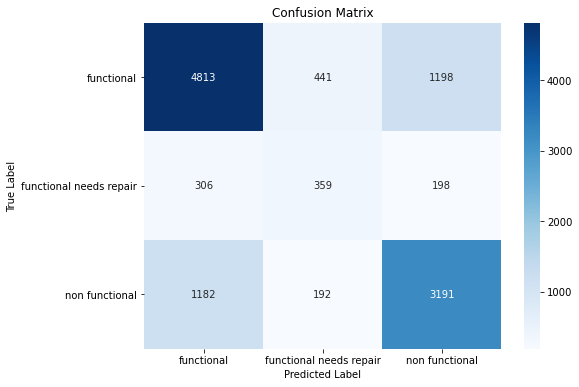

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_va, y_va_hat_rf, labels=['functional', 'functional needs repair', 'non functional'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['functional', 'functional needs repair', 'non functional'], 
            yticklabels=['functional', 'functional needs repair', 'non functional'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Feature Importance

**Feature importance** is a measure of how much each feature contributes to the decision-making process of the model. For the **Random Forest model**, each feature is assigned an importance score based on how well it helps the model reduce error in the predictions.

The chart shows which features have the greatest influence on the model's predictions. Features with higher importance are more likely to be used in the decision-making process, and those with lower importance contribute less.

#### Key Observations:
- Features with the highest importance (e.g., **pump type**, **well age**, etc.) are considered the most influential when the model predicts the status of a well.
- Features with low importance may be candidates for removal if we aim to simplify the model or reduce overfitting.

#### Business Implication:
- Understanding which features drive predictions allows us to focus on improving data collection for those important features.
- If certain features are unexpectedly ranked as highly important (e.g., **installer type**), it may prompt further investigation into data quality or domain-specific factors.


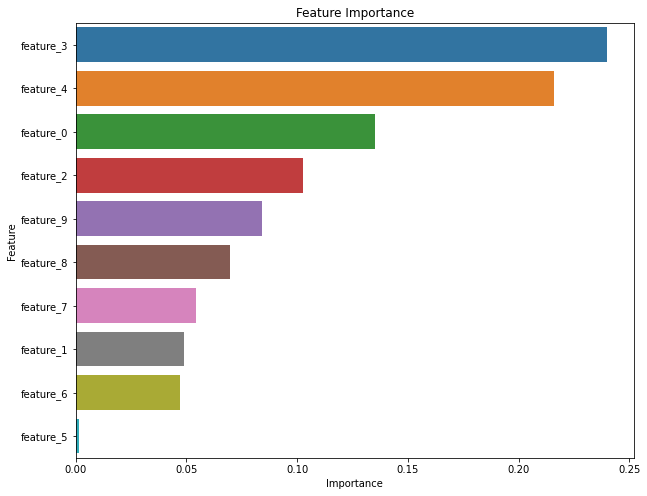

In [30]:
# Extract feature importances from the Random Forest model
importances = best_rf.named_steps['clf'].feature_importances_

# Get the feature names
# Method 1: If using scikit-learn >= 1.0
try:
    # For newer scikit-learn versions
    feature_names = best_rf.named_steps['preprocessor'].get_feature_names_out()
except:
    try:
        # For older scikit-learn versions
        feature_names = best_rf.named_steps['preprocessor'].get_feature_names()
    except:
        # Fallback if the above methods don't work
        # You might need to adjust this based on your specific preprocessing pipeline
        feature_names = [f'feature_{i}' for i in range(len(importances))]

# Create a DataFrame for visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importance')
plt.show()



## Receiver Operating Characteristic (ROC) Curve

The **ROC curve** is used to evaluate the **classification performance** of a model by plotting the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** for various threshold values. It helps in understanding the trade-off between sensitivity and specificity as the threshold changes.

- **True Positive Rate (TPR)**: The proportion of actual positives (non-functional wells) that were correctly identified by the model.
- **False Positive Rate (FPR)**: The proportion of actual negatives (functional wells) that were incorrectly classified as positive (non-functional).

The area under the ROC curve (**AUC**) is a measure of the model's ability to distinguish between the positive and negative classes:
- An **AUC of 1** indicates a perfect model.
- An **AUC of 0.5** indicates a random model.

#### Key Observations:
- The closer the curve is to the top-left corner, the better the model's performance.
- In this case, we are particularly interested in the ROC curve for the **'non-functional' class**, as identifying these wells accurately is crucial for maintenance operations.

#### Business Implication:
- A higher **AUC** indicates a more reliable model for distinguishing between wells that are functional and those that are non-functional.
- By analyzing the ROC curve, stakeholders can adjust the classification threshold to find the best balance between **recall (detecting non-functional wells)** and **precision (minimizing false positives)**.


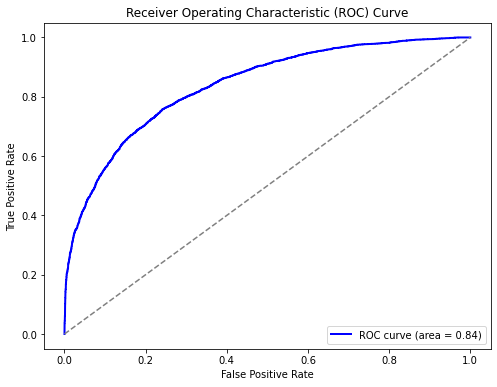

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Binarize the target labels for ROC curve
lb = LabelBinarizer()
y_va_bin = lb.fit_transform(y_va)

# Get the predicted probabilities for each class
y_va_prob = best_rf.predict_proba(X_va)

# Calculate ROC curve for non-functional class (class 2, assuming binary "non functional" vs others)
fpr, tpr, thresholds = roc_curve(y_va_bin[:, 2], y_va_prob[:, 2])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


## Conclusion

This project successfully developed a machine learning model to predict the condition of water wells in Tanzania. The Random Forest model showed the best performance across several metrics, especially recall for non-functional wells, which is critical for prioritizing repairs. The model ensures that resources are allocated effectively, reducing downtime and improving access to clean water.

By deploying this model, NGOs and government agencies can make more informed decisions, optimizing their maintenance efforts and improving water access in rural areas. The model also offers flexibility, allowing for regular updates as new data becomes available, ensuring that predictions remain accurate over time.